In [1]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [2]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d import tiff_utils as tfu
from suite3d import file_utils as flu

In [24]:
job_params = {    
    'notch_filt' :     None,
    'planes' :         n.concatenate([n.arange(0,30,2), n.arange(1,31,2)]),
    'n_ch_tif' : 26,
    'convert_plane_ids_to_channel_ids' : False,
    
    'n_init_files' :   1,
    'init_file_pool' : None,
    'init_file_sample_method': 'random',
    
    'subtract_crosstalk' : True,
    'override_crosstalk' : 0.13,
    'crosstalk_n_planes' : 10, 
    
    'nonrigid' : True,
    'smooth_sigma' : 1.15,
    'maxregshift' : 0.15,
    'reg_filter_pcorr' : 1,
    'generate_sample_registered_bins' : False,

    'dtype' : n.float32,
    'tif_batch_size' : 1,
}



subjects_dir =   '/mnt/zortex-subjects/'
expt_info = { 
    'subject':         'AH012',
    'date' :          '2024-06-07',
    'expnum' :         [8],}

tifs, si_params, exp_str = flu.find_exp(subjects_dir, **expt_info, verbose=False)
job_params['fs'] = si_params['vol_rate']
job_params['fix_fastZ'] = 0

# Create the job
job = Job('/mnt/md0/runs',exp_str, tifs = tifs,
          params=job_params, create=False, overwrite=True, verbosity = 100)

job.params['planes'] = n.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22,  1,  3,
         5,  7,  9, 11, 13, 15, 17])
job.params['3d_reg'] = True
job.params['fuse_shift_override'] = 6
job.params['cavity_size'] = 12
job.verbosity = 100

job.params['gpu_reference_batch_size'] = 10
job.params['gpu_reg_batchsize'] = 10

job.params['init_file_sample_method'] = 'even'
job.params['init_n_frames'] = None
job.params['n_init_files'] = 6

   Found and loaded params from /mnt/md0/runs/s3d-AH012_2024-06-07_8/params.npy


   Saved a copy of params at /mnt/md0/runs/s3d-AH012_2024-06-07_8/summary
   Updated main params file
Launching initial pass
Saving summary to /mnt/md0/runs/s3d-AH012_2024-06-07_8/summary/summary.npy
   Loading init tifs with 26 channels
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/2024-06-07_8_AH012_2P_00001_00008.tif
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/2024-06-07_8_AH012_2P_00001_00016.tif
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/2024-06-07_8_AH012_2P_00001_00024.tif
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/2024-06-07_8_AH012_2P_00001_00032.tif
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/2024-06-07_8_AH012_2P_00001_00040.tif
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/2024-06-07_8_AH012_2P_00001_00048.tif
   Loaded 6 files, total 16.90 GB
   Loaded movie with 600 frames and shape 21, 1000, 720
      Enforcing positivity in mean image
   Subtracting crosstalk with forced coefficient 0.130
         Subtracting pla

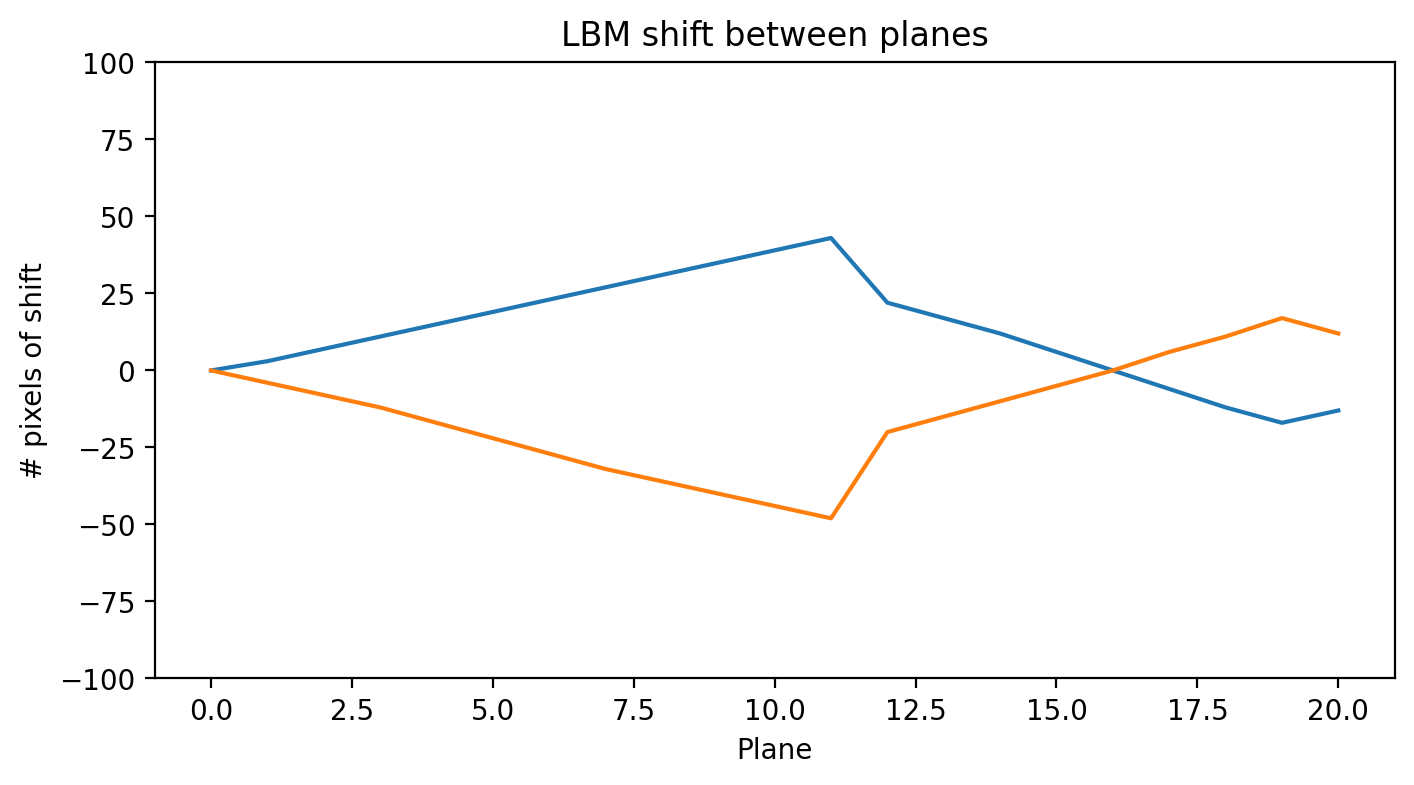

In [36]:
%%time
n.random.seed(5)
summary = job.run_init_pass()

In [37]:
summary = job.load_summary()

In [38]:
ref_vol = summary['ref_img_3d']

In [39]:
sig_range_high = n.percentile(ref_vol, 99.99, axis=(1,2))
sig_range_low = n.percentile(ref_vol, 25, axis=(1,2))

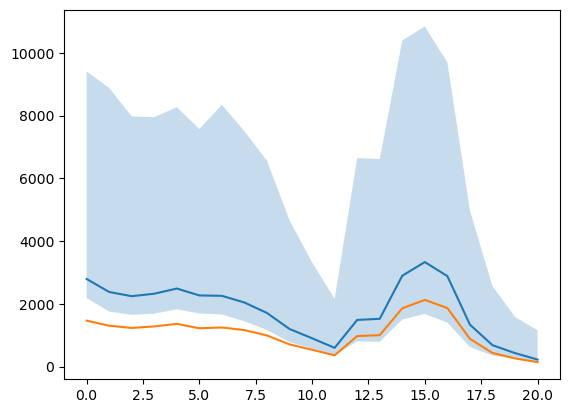

In [40]:
nz, ny, nx = ref_vol.shape

plt.plot(ref_vol.mean(axis=(1,2)))
plt.fill_between(n.arange(nz),sig_range_low, sig_range_high, alpha=0.25)
plt.plot(ref_vol.std(axis=(1,2)))

In [41]:
init_mov = n.load(os.path.join(job.dirs['summary'],'init_mov.npy'))

init_mean = init_mov.mean(axis=1)
init_std = init_mov.std(axis=1)
nz,ny,nx = init_mean.shape

pcts = n.array([n.percentile(init_std[i].flatten(), 98)  for i in range(nz)])

top_pix = [init_std[i] > pcts[i] for i in range(nz)]

top_pix_movs = n.array([init_mov[i][:,top_pix[i]] for i in range(nz)])

ff = top_pix_movs
df = n.diff(ff, axis=1)
dff = df / ff.mean(axis=1,keepdims=True)
abs_d_dff = n.abs(n.diff(dff,axis=1))
noise_level = n.nanmedian(abs_d_dff, axis=1)
noise_level = noise_level / job.params['fs']

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (21, 600) + inhomogeneous part.

In [ ]:
plt.plot((1-noise_level.mean(axis=1)) / noise_level.mean(axis=1))

In [ ]:
plt.plot(noise_level.mean(axis=1))

In [67]:
job.register_gpu_3d(tifs = job.tifs[:2])

      Found dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/registered_fused_data
      Updating self.dirs tag registered_fused_data
   Overriding fuse shift value to 6
   Not clipping frames for registration
Will analyze 2 tifs in 2 batches
   Enforcing positivity
   Launching IO thread
               [Thread] Loading batch 0 

         Memory at batch 0.  Total Used: 213.096 GB, Virtual Available: 305.785 GB, Virtual Used: 197.410 GB, Swap Used: 015.685 GB
Loading Batch 0 of 1
                  [Thread] Before load 0 
Total Used: 213.096 GB, Virtual Available: 305.785 GB, Virtual Used: 197.410 GB, Swap Used: 015.685 GB
      Loading /mnt/zortex-subjects/AH012/2024-06-07/8/2024-06-07_8_AH012_2P_00001_00001.tif


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 0 ready to join after 20.26 sec 

                  [Thread] After load 0 
Total Used: 215.690 GB, Virtual Available: 303.191 GB, Virtual Used: 200.004 GB, Swap Used: 015.686 GB
   Batch 0 IO thread joined
         Memory after IO thread joinTotal Used: 215.690 GB, Virtual Available: 303.191 GB, Virtual Used: 200.004 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 218.508 GB, Virtual Available: 300.373 GB, Virtual Used: 202.823 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 209.204 GB, Virtual Available: 309.677 GB, Virtual Used: 193.518 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
               [Thread] Loading batch 1 

         After IO thread launch:Total Used: 209.204 GB, Virtual Available: 309.677 GB, Virtual Used: 193.518 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 1000, 720)
int16
                 

IndexError: tuple index out of range

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 1 ready to join after 23.32 sec 

                  [Thread] After load 1 
Total Used: 218.580 GB, Virtual Available: 300.301 GB, Virtual Used: 202.895 GB, Swap Used: 015.686 GB


In [ ]:
mov = job.get_registered_movie()

vol = mov[:,:100].mean(axis=1).compute()

summary = job.load_summary()

ref_vol = summary['ref_img_3d']

In [ ]:
print(ref_vol.shape)
print(vol.shape)

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 2.82 GB
               [Thread] Thread for batch 1 ready to join after 24.11 sec 

                  [Thread] After load 1 
Total Used: 212.050 GB, Virtual Available: 306.831 GB, Virtual Used: 196.364 GB, Swap Used: 015.686 GB


In [ ]:
tfu.show_tif(ref_vol[10, :400, :400])

In [ ]:
tfu.show_tif(vol[10, :400, :400])

In [ ]:
job.params['t_batch_size'] = 400
job.params['voxel_size_um'] = (15, 2.5, 2.5)
job.params['npil_filt_type'] = 'unif'
job.params['npil_filt_xy_um'] = 70
job.params['npil_filt_z_um'] = 15.0
job.params['cell_filt_type'] = 'unif'
job.params['cell_filt_xy_um'] = 2.5
job.params['cell_filt_z_um'] = 15.0
job.params['edge_crop_npix'] = 7
job.params['fix_vmap_edge_planes'] = True
job.params['sdnorm_exp'] = 0.85
job.params['intensity_thresh'] = 0.1
job.params['n_proc'] = 32

params_to_sweep = { 
    'cell_filt_xy_um': [2.5, 5.0, 10.0],
    'intensity_thresh' : [0.1, 0.3],
    'sdnorm_exp' : [0.85, 1.0]
}
mov_full = job.get_registered_movie('registered_fused_data', 'fused')
sweep_summary = job.sweep_corrmap(params_to_sweep, mov = mov_full[:,:100],all_combinations=True)

In [61]:
job.params['t_batch_size'] = 400
job.params['voxel_size_um'] = (15, 2.5, 2.5)
job.params['npil_filt_type'] = 'unif'
job.params['npil_filt_xy_um'] = 70
job.params['npil_filt_z_um'] = 15.0
job.params['cell_filt_type'] = 'unif'
job.params['cell_filt_xy_um'] = 10
job.params['cell_filt_z_um'] = 15.0
job.params['edge_crop_npix'] = 7
job.params['fix_vmap_edge_planes'] = True
job.params['sdnorm_exp'] = 0.85
job.params['intensity_thresh'] = 0.1
job.params['n_proc'] = 32
job.calculate_corr_map()

      Found dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/corrmap
      Updating self.dirs tag corrmap
      Found dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/mov_sub
      Updating self.dirs tag mov_sub
   Saved a copy of params at /mnt/md0/runs/s3d-AH012_2024-06-07_8/corrmap
   Updated main params file
   Computing correlation map of movie with 5448 frames, volume shape: 21, 940, 631
      Running batch 1 of 14
         Loading movie into shared memory
         Subtracting neuropil and applying cell filters
         Reducing filtered movie to compute correlation map
      Running batch 2 of 14
         Loading movie into shared memory
         Subtracting neuropil and applying cell filters
         Reducing filtered movie to compute correlation map
      Running batch 3 of 14
         Loading movie into shared memory
         Subtracting neuropil and applying cell filters
         Reducing filtered movie to compute correlation map
      Running batch 4 of 14
         Loading movie into share

array([[[0.        , 0.        , 0.        , ..., 0.23493612,
         0.24423899, 0.25111884],
        [0.        , 0.        , 0.        , ..., 0.23493612,
         0.24423899, 0.25111884],
        [0.        , 0.        , 0.        , ..., 0.22941174,
         0.23844457, 0.24521782],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.08923682,
         0.09472927, 0.10258512],
        [0.        , 0.        , 0.        , ..., 0.08923682,
         0.09472927, 0.10258512],
        [0.        , 0.        , 0.        , ..., 0.08483454,
         0.09033686, 0.09766815],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

In [62]:
results = job.load_corr_map_results()

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f03daaf69a0>)

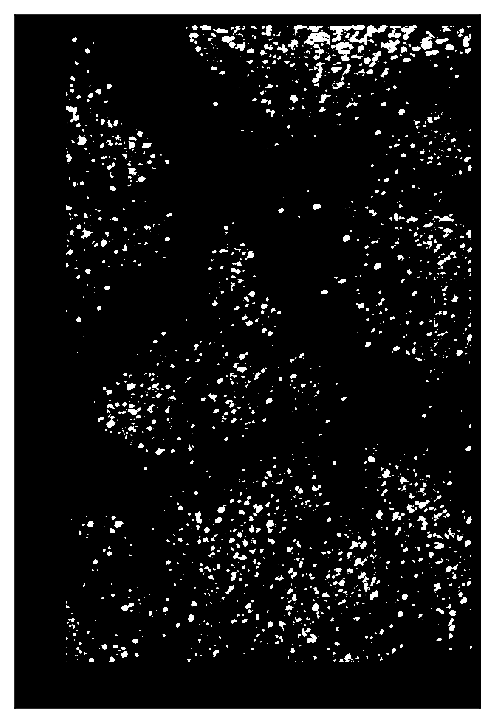

In [63]:
tfu.show_tif(results['vmap'][15], vminmax=(2.0,2.01))

In [68]:
job.params['detection_timebin'] = 1 
job.params['detection_time_crop'] = (None,None)
job.params['max_pix'] = 250
job.params['peak_thresh'] = 2.0

job.params['activity_thresh'] = 20.0
job.params['percentile'] = 99.0
job.params['extend_thresh'] = 0.2
params_to_sweep = {
    'extend_thresh' : (0.15,0.2),
    'percentile'   : (98.0, 99.0, 99.5, 99.9),
 }

job.sweep_segmentation(params_to_sweep, all_combinations=True, patches_to_segment=[30,],ts=(0,6000))

   Setting up sweep
      Found dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/sweeps/seg
      Updating self.dirs tag sweeps-seg
   Total of 8 combinations
      Created directory for comb_00000 with params comb00000-params-extend_thresh_0.150-percentile_98.000
      Found dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/sweeps/seg/comb_00000
      Updating self.dirs tag sweeps-seg-comb_00000
      Created directory for comb_00001 with params comb00001-params-extend_thresh_0.150-percentile_99.000
      Found dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/sweeps/seg/comb_00001
      Updating self.dirs tag sweeps-seg-comb_00001
      Created directory for comb_00002 with params comb00002-params-extend_thresh_0.150-percentile_99.500
      Found dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/sweeps/seg/comb_00002
      Updating self.dirs tag sweeps-seg-comb_00002
      Created directory for comb_00003 with params comb00003-params-extend_thresh_0.150-percentile_99.900
      Found dir /mnt/md0/runs/s3d-AH012_2024-06

         Added cell 57 at 16, 465, 268, peak: 2.070, thresh: 5.902, 133 frames, 17 pixels
         Added cell 58 at 14, 425, 271, peak: 2.069, thresh: 6.124, 146 frames, 20 pixels
         Added cell 59 at 16, 439, 193, peak: 2.068, thresh: 5.924, 132 frames, 47 pixels
         Added cell 60 at 14, 444, 255, peak: 2.066, thresh: 6.061, 138 frames, 24 pixels
         Added cell 61 at 16, 413, 266, peak: 2.065, thresh: 5.869, 179 frames, 51 pixels
         Added cell 62 at 08, 460, 244, peak: 2.065, thresh: 6.039, 191 frames, 100 pixels
         Added cell 63 at 07, 458, 228, peak: 2.064, thresh: 6.268, 129 frames, 21 pixels
         Added cell 64 at 15, 414, 231, peak: 2.064, thresh: 6.459, 131 frames, 19 pixels
         Iter 0008: running 08 ROIs in parallel
         Added cell 65 at 15, 442, 251, peak: 2.066, thresh: 6.079, 145 frames, 13 pixels
         Added cell 66 at 16, 468, 254, peak: 2.059, thresh: 5.965, 146 frames, 21 pixels
         Added cell 67 at 14, 378, 262, peak: 2.059

         Added cell 1 at 17, 408, 268, peak: 2.844, thresh: 9.655, 258 frames, 74 pixels
         Added cell 2 at 15, 448, 245, peak: 2.804, thresh: 10.641, 127 frames, 30 pixels
         Added cell 3 at 07, 453, 267, peak: 2.737, thresh: 10.282, 166 frames, 101 pixels
         Added cell 4 at 14, 455, 200, peak: 2.588, thresh: 9.948, 102 frames, 40 pixels
         Added cell 5 at 15, 442, 189, peak: 2.535, thresh: 9.578, 148 frames, 52 pixels
         Added cell 6 at 00, 463, 196, peak: 2.462, thresh: 9.473, 95 frames, 41 pixels
         Added cell 7 at 07, 465, 216, peak: 2.428, thresh: 8.353, 266 frames, 188 pixels
         Added cell 8 at 14, 393, 271, peak: 2.426, thresh: 9.243, 171 frames, 138 pixels
         Iter 0001: running 08 ROIs in parallel
         Added cell 9 at 17, 455, 206, peak: 2.400, thresh: 8.400, 94 frames, 26 pixels
         Added cell 10 at 16, 437, 196, peak: 2.354, thresh: 7.496, 155 frames, 51 pixels
         Added cell 11 at 06, 468, 192, peak: 2.345, thres

         Added cell 89 at 00, 439, 232, peak: 2.023, thresh: 6.850, 81 frames, 37 pixels
         Added cell 90 at 15, 458, 215, peak: 2.021, thresh: 6.871, 66 frames, 20 pixels
         Added cell 91 at 00, 466, 203, peak: 2.020, thresh: 6.952, 69 frames, 14 pixels
         Added cell 92 at 10, 390, 270, peak: 2.018, thresh: 7.475, 100 frames, 36 pixels
         Added cell 93 at 07, 457, 236, peak: 2.018, thresh: 7.103, 71 frames, 35 pixels
         Added cell 94 at 10, 433, 266, peak: 2.018, thresh: 7.587, 94 frames, 101 pixels
         Added cell 95 at 06, 449, 200, peak: 2.017, thresh: 6.871, 91 frames, 34 pixels
         Added cell 96 at 14, 447, 253, peak: 2.017, thresh: 6.821, 84 frames, 52 pixels
         Iter 0012: running 08 ROIs in parallel
         Added cell 97 at 14, 427, 268, peak: 2.017, thresh: 6.945, 70 frames, 9 pixels
         Added cell 98 at 00, 451, 210, peak: 2.014, thresh: 6.999, 69 frames, 13 pixels
         Added cell 99 at 15, 443, 192, peak: 2.013, thresh: 

         Added cell 49 at 13, 396, 261, peak: 2.088, thresh: 8.934, 41 frames, 55 pixels
         Added cell 50 at 14, 464, 189, peak: 2.086, thresh: 8.192, 40 frames, 34 pixels
         Added cell 51 at 14, 466, 210, peak: 2.083, thresh: 7.874, 58 frames, 47 pixels
         Added cell 52 at 14, 443, 257, peak: 2.082, thresh: 9.127, 35 frames, 35 pixels
         Added cell 53 at 15, 460, 251, peak: 2.082, thresh: 7.703, 62 frames, 63 pixels
         Added cell 54 at 06, 468, 211, peak: 2.081, thresh: 8.415, 161 frames, 251 pixels
         Added cell 55 at 10, 458, 195, peak: 2.074, thresh: 8.228, 65 frames, 35 pixels
         Added cell 56 at 15, 455, 218, peak: 2.071, thresh: 8.012, 45 frames, 25 pixels
         Iter 0007: running 08 ROIs in parallel
         Added cell 57 at 16, 465, 268, peak: 2.070, thresh: 7.929, 37 frames, 37 pixels
         Added cell 58 at 14, 425, 271, peak: 2.069, thresh: 8.360, 55 frames, 38 pixels
         Added cell 59 at 16, 439, 193, peak: 2.068, thresh:

         Added cell 9 at 17, 455, 206, peak: 2.400, thresh: 14.806, 22 frames, 36 pixels
         Added cell 10 at 16, 437, 196, peak: 2.354, thresh: 10.504, 41 frames, 62 pixels
         Added cell 11 at 06, 468, 192, peak: 2.345, thresh: 15.065, 45 frames, 157 pixels
         Added cell 12 at 14, 448, 257, peak: 2.344, thresh: 13.950, 22 frames, 79 pixels
         Added cell 13 at 08, 420, 236, peak: 2.339, thresh: 11.997, 113 frames, 189 pixels
         Added cell 14 at 15, 432, 201, peak: 2.328, thresh: 11.591, 44 frames, 45 pixels
         Added cell 15 at 00, 461, 271, peak: 2.291, thresh: 11.340, 259 frames, 105 pixels
         Added cell 16 at 00, 427, 249, peak: 2.271, thresh: 10.323, 16 frames, 46 pixels
         Iter 0002: running 08 ROIs in parallel
         Added cell 17 at 08, 398, 269, peak: 2.269, thresh: 11.622, 59 frames, 176 pixels
         Added cell 18 at 07, 453, 271, peak: 2.268, thresh: 11.208, 27 frames, 110 pixels
         Added cell 19 at 07, 459, 203, peak: 

         Added cell 97 at 15, 463, 203, peak: 2.004, thresh: 10.731, 6 frames, 94 pixels
         Added cell 98 at 02, 468, 195, peak: 2.003, thresh: 9.429, 38 frames, 283 pixels
         Added cell 99 at 13, 462, 224, peak: 2.001, thresh: 10.678, 13 frames, 28 pixels
         Added cell 100 at 01, 428, 247, peak: 2.000, thresh: 9.175, 39 frames, 66 pixels
      Iter 0013: peak is too small  - ending extraction
   Found 100 cells in 13 iterations
   Saving cells to /mnt/md0/runs/s3d-AH012_2024-06-07_8/sweeps/seg/comb_00003/segmentation/patch-0030/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-AH012_2024-06-07_8/sweeps/seg/comb_00003/segmentation/patch-0030/iscell.npy
      Found dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/sweeps/seg/comb_00003/segmentation/patch-0030
      Updating self.dirs tag sweeps-seg-comb_00003-segmentation-sweeps-seg-comb_00003-segmentation-patch-0030
      Deduplicating 100 cells
      Removed 0 duplicate cells in 0.01s
   Combined 1 patches, 100 cells
   Sav

         Added cell 68 at 15, 414, 231, peak: 2.064, thresh: 6.459, 123 frames, 15 pixels
         Added cell 69 at 16, 468, 254, peak: 2.059, thresh: 5.965, 150 frames, 14 pixels
         Added cell 70 at 14, 378, 262, peak: 2.059, thresh: 5.986, 118 frames, 14 pixels
         Added cell 71 at 04, 466, 187, peak: 2.059, thresh: 5.917, 139 frames, 13 pixels
         Added cell 72 at 00, 429, 247, peak: 2.056, thresh: 6.094, 128 frames, 14 pixels
         Iter 0009: running 08 ROIs in parallel
         Added cell 73 at 13, 468, 233, peak: 2.054, thresh: 6.506, 126 frames, 14 pixels
         Added cell 74 at 15, 444, 191, peak: 2.053, thresh: 5.838, 114 frames, 11 pixels
         Added cell 75 at 09, 464, 188, peak: 2.052, thresh: 6.250, 160 frames, 20 pixels
         Added cell 76 at 00, 457, 237, peak: 2.051, thresh: 6.058, 117 frames, 9 pixels
         Added cell 77 at 15, 445, 264, peak: 2.048, thresh: 6.012, 121 frames, 17 pixels
         Added cell 78 at 09, 436, 231, peak: 2.045, 

         Added cell 9 at 17, 455, 206, peak: 2.400, thresh: 8.400, 96 frames, 20 pixels
         Added cell 10 at 16, 437, 196, peak: 2.354, thresh: 7.496, 151 frames, 33 pixels
         Added cell 11 at 06, 468, 192, peak: 2.345, thresh: 9.161, 148 frames, 103 pixels
         Added cell 12 at 14, 448, 257, peak: 2.344, thresh: 8.581, 76 frames, 31 pixels
         Added cell 13 at 08, 420, 236, peak: 2.339, thresh: 8.143, 277 frames, 117 pixels
         Added cell 14 at 15, 432, 201, peak: 2.328, thresh: 7.979, 113 frames, 26 pixels
         Added cell 15 at 00, 461, 271, peak: 2.291, thresh: 8.101, 549 frames, 75 pixels
         Added cell 16 at 00, 427, 249, peak: 2.271, thresh: 7.578, 99 frames, 26 pixels
         Iter 0002: running 08 ROIs in parallel
         Added cell 17 at 08, 398, 269, peak: 2.269, thresh: 7.605, 157 frames, 92 pixels
         Added cell 18 at 07, 453, 271, peak: 2.268, thresh: 7.246, 130 frames, 35 pixels
         Added cell 19 at 07, 459, 203, peak: 2.253, t

         Added cell 97 at 00, 466, 203, peak: 2.020, thresh: 6.952, 67 frames, 10 pixels
         Added cell 98 at 14, 457, 248, peak: 2.020, thresh: 6.744, 75 frames, 19 pixels
         Added cell 99 at 15, 447, 248, peak: 2.019, thresh: 6.867, 62 frames, 9 pixels
         Added cell 100 at 13, 459, 203, peak: 2.019, thresh: 6.993, 73 frames, 10 pixels
         Added cell 101 at 10, 390, 270, peak: 2.018, thresh: 7.475, 94 frames, 20 pixels
         Added cell 102 at 07, 457, 236, peak: 2.018, thresh: 7.103, 65 frames, 15 pixels
         Added cell 103 at 10, 433, 266, peak: 2.018, thresh: 7.587, 79 frames, 59 pixels
         Added cell 104 at 06, 449, 200, peak: 2.017, thresh: 6.871, 82 frames, 25 pixels
         Iter 0013: running 08 ROIs in parallel
         Added cell 105 at 14, 447, 253, peak: 2.017, thresh: 6.821, 72 frames, 24 pixels
         Added cell 106 at 14, 427, 268, peak: 2.017, thresh: 6.953, 66 frames, 9 pixels
         Added cell 107 at 00, 451, 210, peak: 2.014, thr

         Added cell 41 at 07, 452, 202, peak: 2.127, thresh: 8.809, 78 frames, 134 pixels
         Added cell 42 at 14, 455, 203, peak: 2.124, thresh: 7.751, 91 frames, 25 pixels
         Added cell 43 at 16, 412, 265, peak: 2.120, thresh: 8.970, 82 frames, 51 pixels
         Added cell 44 at 09, 442, 208, peak: 2.116, thresh: 8.882, 88 frames, 67 pixels
         Added cell 45 at 10, 440, 271, peak: 2.115, thresh: 9.173, 65 frames, 51 pixels
         Added cell 46 at 09, 402, 261, peak: 2.114, thresh: 9.544, 93 frames, 138 pixels
         Added cell 47 at 06, 467, 218, peak: 2.114, thresh: 7.760, 42 frames, 18 pixels
         Added cell 48 at 15, 467, 233, peak: 2.111, thresh: 8.865, 37 frames, 21 pixels
         Iter 0006: running 08 ROIs in parallel
         Added cell 49 at 04, 453, 195, peak: 2.103, thresh: 8.123, 85 frames, 92 pixels
         Added cell 50 at 09, 448, 209, peak: 2.101, thresh: 8.265, 62 frames, 31 pixels
         Added cell 51 at 15, 389, 271, peak: 2.089, thresh:

      Found dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/sweeps/seg/comb_00007/segmentation
      Updating self.dirs tag sweeps-seg-comb_00007-segmentation
   Saved a copy of params at /mnt/md0/runs/s3d-AH012_2024-06-07_8/sweeps/seg/comb_00007/segmentation
   Updated main params file
      Found dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/sweeps/seg/comb_00007/rois
      Updating self.dirs tag sweeps-seg-comb_00007-rois
   Saving results to /mnt/md0/runs/s3d-AH012_2024-06-07_8/sweeps/seg/comb_00007/segmentation and /mnt/md0/runs/s3d-AH012_2024-06-07_8/sweeps/seg/comb_00007/rois 
dict_keys(['max_img', 'mean_img', 'vmap', 'all_params'])
   Detecting from patch 1 / 1
      Found dir /mnt/md0/runs/s3d-AH012_2024-06-07_8/sweeps/seg/comb_00007/segmentation/patch-0030
         Loading 6.14 GB movie to memory, shape: (5448, 21, 120, 120) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 2.000 and Th2: 20.000
         Iter 0000: 

         Added cell 77 at 07, 457, 265, peak: 2.037, thresh: 9.250, 22 frames, 30 pixels
         Added cell 78 at 17, 424, 194, peak: 2.036, thresh: 11.874, 7 frames, 18 pixels
         Added cell 79 at 07, 419, 213, peak: 2.036, thresh: 10.313, 51 frames, 167 pixels
         Added cell 80 at 12, 431, 268, peak: 2.033, thresh: 10.666, 10 frames, 35 pixels
         Iter 0010: running 08 ROIs in parallel
         Added cell 81 at 05, 433, 191, peak: 2.031, thresh: 10.397, 35 frames, 75 pixels
         Added cell 82 at 09, 452, 247, peak: 2.031, thresh: 11.729, 36 frames, 135 pixels
         Added cell 83 at 13, 426, 266, peak: 2.030, thresh: 11.146, 9 frames, 28 pixels
         Added cell 84 at 09, 390, 257, peak: 2.028, thresh: 11.100, 50 frames, 120 pixels
         Added cell 85 at 15, 453, 244, peak: 2.027, thresh: 9.144, 18 frames, 36 pixels
         Added cell 86 at 04, 398, 246, peak: 2.026, thresh: 10.357, 31 frames, 180 pixels
         Added cell 87 at 04, 457, 233, peak: 2.023,

{'sweep_dir_path': '/mnt/md0/runs/s3d-AH012_2024-06-07_8/sweeps/seg',
 'sweep_dir_name': 'sweeps-seg',
 'init_params': {'fs': 4.481862197392922,
  'tau': 1.3,
  'voxel_size_um': (15, 2.5, 2.5),
  'planes': array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22,  1,  3,  5,  7,  9,
         11, 13, 15, 17]),
  'convert_plane_ids_to_channel_ids': False,
  'n_ch_tif': 26,
  'notch_filt': None,
  'fix_fastZ': 0,
  'n_init_files': 6,
  'init_file_pool': None,
  'init_file_sample_method': 'even',
  'init_n_frames': None,
  'enforce_positivity': True,
  'fix_shallow_plane_shift_estimates': True,
  'fix_shallow_plane_shift_esimate_threshold': 20,
  'overwrite_plane_shifts': None,
  'subtract_crosstalk': True,
  'override_crosstalk': 0.13,
  'crosstalk_percentile': 99.5,
  'crosstalk_sigma': 0.01,
  'cavity_size': 12,
  'crosstalk_n_planes': 10,
  'use_GPU_registration': True,
  'fuse_strips': True,
  'fuse_shift_override': 6,
  'max_rigid_shift_pix': 100,
  'gpu_reg_batchsize': 10,
  'max_shift